In [1]:
from datasets import load_dataset


train_dataset = load_dataset("csv", data_files="..\datasets\soham-articles\\bn\\bn-train.csv", column_names=["labels","text"], split="train")

Found cached dataset csv (C:/Users/arifa/.cache/huggingface/datasets/csv/default-288983945b809be3/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [2]:
valid_dataset = load_dataset("csv", data_files="..\datasets\soham-articles\\bn\\bn-valid.csv", column_names=["labels","text"], split="train")

Found cached dataset csv (C:/Users/arifa/.cache/huggingface/datasets/csv/default-934cec49a13b53ff/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [3]:
test_dataset = load_dataset("csv", data_files="..\datasets\soham-articles\\bn\\bn-test.csv", column_names=["labels","text"], split="train")

Found cached dataset csv (C:/Users/arifa/.cache/huggingface/datasets/csv/default-04dc69dd625404f0/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [4]:
from datasets import Dataset, DatasetDict

news_datasets = DatasetDict()
news_datasets['train'] = train_dataset
news_datasets['test'] = test_dataset
news_datasets['validation'] = valid_dataset

In [5]:
news_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 11284
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 1411
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 1411
    })
})

In [6]:
train_dataset.set_format("pandas")

In [7]:
# get label counts for both classes
label_counts = train_dataset["labels"].value_counts()
num_labels = (len(label_counts.keys()))

In [8]:
label_counts

labels
kolkata          4603
state            2245
national         1435
sports           1289
entertainment    1186
international     526
Name: count, dtype: int64

In [9]:
max_token_length = max(train_dataset['text'].str.len())
max_token_length

13776

In [10]:
count = train_dataset['text'].str.split().apply(len).value_counts()

In [11]:
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)

In [12]:
count

text
100 words:     28
1002 words:     2
101 words:     20
1013 words:     1
1017 words:     1
               ..
98 words:      25
987 words:      1
99 words:      19
992 words:      1
999 words:      1
Name: count, Length: 771, dtype: int64

In [13]:
train_dataset.reset_format()

In [14]:
from transformers import set_seed

set_seed(30)
# set_seed(42)

In [15]:
from transformers import BertForSequenceClassification, BertConfig, CharacterBertModel, CharacterBertTokenizer

#### LOADING BERT FOR CLASSIFICATION ####

config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)  # binary classification
model = BertForSequenceClassification(config=config)

In [16]:
model.bert.embeddings.word_embeddings  # wordpiece embeddings

Embedding(30522, 768, padding_idx=0)

In [17]:
#### REPLACING BERT WITH CHARACTER_BERT ####

character_bert_model = CharacterBertModel.from_pretrained(
    "E:\Documents\Character Bert\Question Classification\character-bert")
model.bert = character_bert_model

Some weights of the model checkpoint at E:\Documents\Character Bert\Question Classification\character-bert were not used when initializing CharacterBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing CharacterBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CharacterBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
model.bert.embeddings.word_embeddings  # wordpieces are replaced with a CharacterCNN

CharacterCnn(
  (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
  (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
  (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
  (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
  (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
  (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
  (_highways): Highway(
    (_layers): ModuleList(
      (0-1): 2 x Linear(in_features=2048, out_features=4096, bias=True)
    )
  )
  (_projection): Linear(in_features=2048, out_features=768, bias=True)
)

In [19]:
# import torch

# # Load the actual checkpoint file
# checkpoint = torch.load(
#     output_directory, map_location="cpu"
# )

In [20]:
# model.load_state_dict(checkpoint['model'], strict=True)

In [21]:
tokenizer = CharacterBertTokenizer(strip_accents=None, do_lower_case=None)

In [22]:
def tokenize_function(example):
    return tokenizer(example["text"], max_length=128)

In [23]:
from transformers import DataCollatorWithPadding

tokenized_datasets = news_datasets.map(tokenize_function, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\csv\default-288983945b809be3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-e98e8e56455d1237.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\csv\default-04dc69dd625404f0\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-b118f805ce8ac4b0.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\csv\default-934cec49a13b53ff\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-e8a6e6f18f150f3b.arrow


In [24]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11284
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1411
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1411
    })
})

In [25]:
# temp = tokenized_datasets.filter(lambda x:x if tokenizer.unk_token_id in x["input_ids"] else None)

In [26]:
# temp

In [27]:
# for sample in temp["train"]:
#     print(tokenizer.decode(sample["input_ids"]))

In [28]:
# "kolkata":4603,
# "state":2245,
# "national":1435,
# "sports":1289,
# "entertainment":1186,
# "international":526

In [29]:
def assign_label(example):
    mapping = {
        "kolkata":0,
        "state":1,
        "national":2,
        "sports":3,
        "entertainment":4,
        "international":5
    }
    example['labels'] = mapping[example['labels']]
    return example

In [30]:
tokenized_datasets = tokenized_datasets.map(assign_label)
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\csv\default-288983945b809be3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-07499d1639bcd994.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\csv\default-04dc69dd625404f0\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-8fd5c59463e59219.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\csv\default-934cec49a13b53ff\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-ac1979357c97e3dd.arrow


{'train': ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
 'test': ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
 'validation': ['labels', 'input_ids', 'token_type_ids', 'attention_mask']}

In [31]:
samples = [tokenized_datasets["train"][i] for i in range(5)]
samples

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] প্রজাপতি প্রজাপতি আমার ইচ্ছে হয়ে, বনে বনে ঘাসে ঘাসে ওড়ে আর ফেরে... সেই সুর যা ফিরিয়ে দেয় শৈশবের সুগন্ধ । সবিতা চৌধুরী । যাঁর কণ্ঠ অপূর্ব সব গানগুচ্ছ উপহার দিয়েছে সব প্রজন্মের গানপ্রেমীদের । দুরারোগ্য কর্কটরোগে আক্রান্ত সেদিনের সবিতা । গত কয়েক বছর ধরে নিরন্তর লড়াইয়ের পর এখন প্রহর গুনছেন । যেকোনও দিনই আসতে পারে সেই ভয়ঙ্কর দিনটি । এখন তাঁর বড় মেয়ে অন্তরা চৌধুরীর কাছেই আছেন তিনি । রুবি হাসপাতালের খুব কাছেই বড় মেয়ের কাছেই কাটাতে চান জীবনের শেষ কয়েকটি দিন । আজই এবেলা. ইন কে জানালেন অন্তরা । স্বামী সলিল চৌধুরীর অনুরোধেই প্রথম অ্যালবামে গাওয়া গান মরি হায় গো হায় । সবিতার কণ্ঠস্বরের জাদুতে সেই গান শাশ্বত হয়ে আছে । এখন এই আনন্দের শহরে একলা শুয়ে সবিতা । সুরের [SEP]'

'>>> [CLS] দীর্ঘ সাত মাসের প্রতীক্ষার পর সোমবার সকালে এসে পৌঁছল কলকাতা মেট্রো রেলের নতুন এসি রেক । গত ডিসেম্বরে ওই রেকটি এসে পৌঁছনোর কথা থাকলেও একাধিক কারণে রেক পেতে অনেকটা দেরি হল বলে মেট্রো সূত্রের খবর । চেন্নাইয়ের ইন্টিগ্রাল কোচ ফ্যাক্টরিকে ( আইসিএফ ) দু ’ টি এসি রেকের বরাত দেওয়া হয়েছিল । তার মধ্যে প্রথম রেকটি এদিন 

In [32]:
news_datasets["train"][:5]

{'labels': ['entertainment', 'state', 'state', 'sports', 'national'],
 'text': ['প্রজাপতি প্রজাপতি আমার ইচ্ছে হয়ে, বনে বনে ঘাসে ঘাসে ওড়ে আর ফেরে...\nসেই সুর যা ফিরিয়ে দেয় শৈশবের সুগন্ধ। সবিতা চৌধুরী। যাঁর কণ্ঠ অপূর্ব সব গানগুচ্ছ উপহার দিয়েছে সব প্রজন্মের গানপ্রেমীদের। দুরারোগ্য কর্কটরোগে আক্রান্ত সেদিনের সবিতা। গত কয়েক বছর ধরে নিরন্তর লড়াইয়ের পর এখন প্রহর গুনছেন । যেকোনও দিনই আসতে পারে সেই ভয়ঙ্কর দিনটি।\nএখন তাঁর বড় মেয়ে অন্তরা চৌধুরীর কাছেই আছেন তিনি। রুবি হাসপাতালের খুব কাছেই বড় মেয়ের কাছেই কাটাতে চান জীবনের শেষ কয়েকটি দিন। আজই এবেলা.ইন কে জানালেন অন্তরা।\nস্বামী সলিল চৌধুরীর অনুরোধেই প্রথম অ্যালবামে গাওয়া গান মরি হায় গো হায়। সবিতার কণ্ঠস্বরের জাদুতে সেই গান শাশ্বত হয়ে আছে।\xa0\nএখন এই আনন্দের শহরে একলা শুয়ে সবিতা। সুরের সেই ঝর-ঝর-ঝরণা যে আজ নিরুচ্চার',
  'দীর্ঘ সাত মাসের প্রতীক্ষার পর সোমবার সকালে এসে পৌঁছল কলকাতা মেট্রো রেলের নতুন এসি রেক। গত ডিসেম্বরে ওই রেকটি এসে পৌঁছনোর কথা থাকলেও একাধিক কারণে রেক পেতে অনেকটা দেরি হল বলে মেট্রো সূত্রের খবর।\xa0\nচেন্নাইয়ের ইন্টিগ্রাল কোচ ফ্য

In [33]:
from torch.utils.data import DataLoader
# batch_size = 16
batch_size = 32

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [34]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([32]),
 'input_ids': torch.Size([32, 128, 50]),
 'token_type_ids': torch.Size([32, 128]),
 'attention_mask': torch.Size([32, 128])}

In [35]:
import torch
with torch.no_grad():
    outputs = model(**batch)
    print(outputs.loss, outputs.logits.shape)

tensor(1.8421) torch.Size([32, 6])


In [36]:
import numpy as np
import evaluate

metric_fun = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    metric_result = metric_fun.compute(references=labels, predictions=predictions)
    return {
        "accuracy": metric_result["accuracy"],
    }

In [37]:
#  disable weights and biases logging
import os
os.environ["WANDB_DISABLED"] = "true"

In [38]:
from transformers import TrainingArguments

# batch_size = 16
batch_size = 32
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size


training_args = TrainingArguments(
    output_dir="models/bert-unigram-bengali-classifier",
    overwrite_output_dir=True,
    report_to = None,
    logging_dir= None,
    save_strategy="no",
    evaluation_strategy="epoch",
    #learning_rate=2e-5,
    learning_rate=3e-5,
    weight_decay=0.01,
    #weight_decay=0.02,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    #num_train_epochs=6,
    #push_to_hub=True,
    fp16=True,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [39]:
# from datasets import concatenate_datasets

# entire_train = concatenate_datasets([tokenized_datasets["train"], tokenized_datasets["validation"]]) 

In [40]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    #train_dataset=entire_train,
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using amp half precision backend


In [41]:
import transformers
trainer.remove_callback(transformers.integrations.TensorBoardCallback)

In [42]:
trainer.evaluate(tokenized_datasets["validation"])

***** Running Evaluation *****
  Num examples = 1411
  Batch size = 32


{'eval_loss': 1.8308228254318237,
 'eval_accuracy': 0.1261516654854713,
 'eval_runtime': 13.0509,
 'eval_samples_per_second': 108.115,
 'eval_steps_per_second': 3.448}

In [43]:
trainer.train()

***** Running training *****
  Num examples = 11284
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1765


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.487805,0.829908
2,0.589400,0.423985,0.866052
3,0.325300,0.350479,0.887314
4,0.325300,0.361164,0.890149
5,0.187200,0.375412,0.896527


***** Running Evaluation *****
  Num examples = 1411
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1411
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1411
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1411
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1411
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1765, training_loss=0.32843787649873296, metrics={'train_runtime': 771.648, 'train_samples_per_second': 73.116, 'train_steps_per_second': 2.287, 'total_flos': 2.25781730044416e+17, 'train_loss': 0.32843787649873296, 'epoch': 5.0})

In [44]:
trainer.evaluate(tokenized_datasets["test"])

***** Running Evaluation *****
  Num examples = 1411
  Batch size = 32


{'eval_loss': 0.29614242911338806,
 'eval_accuracy': 0.9192062367115521,
 'eval_runtime': 8.963,
 'eval_samples_per_second': 157.425,
 'eval_steps_per_second': 5.021,
 'epoch': 5.0}

In [45]:
output_directory = "best-model"

In [46]:
torch.save(
    {
        'model': model.state_dict(),
    },
    output_directory
)

In [48]:
y_preds, y_true, _ = trainer.predict(tokenized_datasets["test"])

***** Running Prediction *****
  Num examples = 1411
  Batch size = 32


In [49]:
y_preds = np.argmax(y_preds, axis=-1)

In [50]:
from sklearn.metrics import classification_report
target_names = ["kolkata",
        "state",
        "national",
        "sports",
        "entertainment",
        "international"]

print(classification_report(y_true, y_preds,target_names=target_names))

               precision    recall  f1-score   support

      kolkata       0.97      0.98      0.98       569
        state       0.86      0.91      0.88       279
     national       0.87      0.77      0.81       175
       sports       0.97      0.96      0.96       192
entertainment       0.87      0.89      0.88       130
international       0.82      0.77      0.80        66

     accuracy                           0.92      1411
    macro avg       0.89      0.88      0.89      1411
 weighted avg       0.92      0.92      0.92      1411



In [53]:
# !pip install seaborn

Text(0.5, 1.0, 'Confusion matrix for QC')

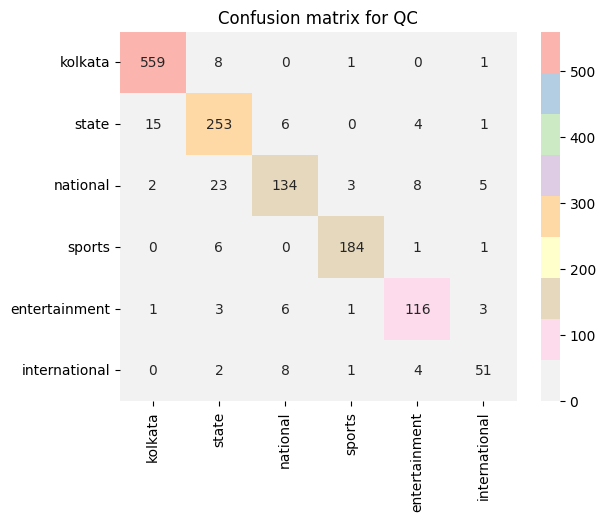

In [54]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

#plot heatmap of confusion matrix
mat = confusion_matrix(y_true, y_preds)
heatmap(mat, cmap="Pastel1_r", fmt="d", xticklabels=target_names, yticklabels=target_names, annot=True)

#add overall title to plot
plt.title('Confusion matrix for QC', fontsize = 12) # title with fontsize 20

In [55]:
misclassified = [i for i in range(len(y_preds)) if ((y_preds[i] != y_true[i]) and (y_true[i]==5) and (y_preds[i]==2))]

In [56]:
misclassified = test_dataset.select(misclassified)

In [57]:
misclassified[:]

{'labels': ['international',
  'international',
  'international',
  'international',
  'international',
  'international',
  'international',
  'international'],
 'text': ['ক’দিন আগেই যে দেশটার পক্ষে দাঁড়িয়ে রাষ্ট্রপুঞ্জে জেরুসালেম ইস্যুতে ভোট দিয়েছে ভারত, সেই প্যালেস্তাইনের রাষ্ট্রদূতকেই দেখা গেল মুম্বই হামলার মাস্টারমাইন্ড হাফিজ সইদের মঞ্চে। শুক্রবার পাকিস্তানের রাওয়ালপিন্ডিতে একটি সভার আয়োজন করেছিল হাফিজের দিফা-ই-পাকিস্তান কাউন্সিল। সেখানেই দেখা গেল পাকিস্তানে নিযুক্ত প্যালেস্তিনীয় রাষ্ট্রদূত আবু আলিকে। এবং মঞ্চে তিনি বসেছিলেন জামাত প্রধান হাফিজ সইদের পাশেই। সেই ছবি ছড়িয়ে পড়তেই তীব্র প্রতিক্রিয়া জানিয়েছে নয়াদিল্লি। কেন্দ্রীয় বিদেশমন্ত্রকের তরফে বিবৃতি দিয়ে বলা হয়, “বিষয়টি খুব গুরুত্ব দিয়ে দেখা হচ্ছে। নয়াদিল্লিতে প্যালেস্তাইনের রাষ্ট্রদূতের কাছে বিষয়টি তুলে ধরা হবে।” প্রতিক্রিয়া যেমনই হোক, এই ঘটনা নয়াদিল্লির পক্ষে যথেষ্ট অস্বস্তি এবং বিড়ম্বনার কারণও যে হয়েছে তাতে সন্দেহ নেই। কারণ জেরুজালেম ইস্যুতে ভারত রাষ্ট্রপুঞ্জে ভোট দিয়েছে নিজের ‘স্ট্র্যাটেজিক পার্টনার’ আমেরিকা এবং ক্রমশ আরও

In [47]:
# model.save_pretrained("models/bert-unigram-bengali-classifier")

In [233]:
# trainer.save_model()

In [255]:
#### LOADING BERT FOR CLASSIFICATION ####

model = BertForSequenceClassification.from_pretrained("models/bert-unigram-bengali-classifier", num_labels=num_labels)

loading configuration file models/bert-unigram-bengali-classifier\config.json
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.16.0.dev0",
  "type

In [256]:
#### REPLACING BERT WITH CHARACTER_BERT ####

character_bert_model = CharacterBertModel.from_pretrained("models/bert-unigram-bengali-classifier")
model.bert = character_bert_model

loading configuration file models/bert-unigram-bengali-classifier\config.json
You are using a model of type bert to instantiate a model of type character_bert. This is not supported for all configurations of models and can yield errors.
Model config CharacterBertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "character_embeddings_dim": 16,
  "classifier_dropout": null,
  "cnn_activation": "relu",
  "cnn_filters": [
    [
      1,
      32
    ],
    [
      2,
      32
    ],
    [
      3,
      64
    ],
    [
      4,
      128
    ],
    [
      5,
      256
    ],
    [
      6,
      512
    ],
    [
      7,
      1024
    ]
  ],
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "interme

Some weights of CharacterBertModel were not initialized from the model checkpoint at models/bert-unigram-bengali-classifier and are newly initialized: ['encoder.layer.4.attention.self.key.bias', 'encoder.layer.1.attention.output.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.4.attention.output.LayerNorm.weight', 'encoder.layer.8.output.dense.weight', 'embeddings.word_embeddings.char_conv_6.bias', 'encoder.layer.9.output.LayerNorm.bias', 'embeddings.word_embeddings.char_conv_1.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.9.attention.output.dense.bias', 'encoder.layer.2.attention.output.dense.weight', 'encoder.layer.1.attention.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.4.attention.self.key.weight', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.10.attention.self.qu

In [257]:
model.bert.embeddings.word_embeddings

CharacterCnn(
  (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
  (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
  (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
  (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
  (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
  (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
  (_highways): Highway(
    (_layers): ModuleList(
      (0-1): 2 x Linear(in_features=2048, out_features=4096, bias=True)
    )
  )
  (_projection): Linear(in_features=2048, out_features=768, bias=True)
)

In [258]:
# model = AutoModelForSequenceClassification.from_pretrained("models/bert-unigram-bengali-classifier")
model.to("cuda")

BertForSequenceClassification(
  (bert): CharacterBertModel(
    (embeddings): CharacterBertEmbeddings(
      (word_embeddings): CharacterCnn(
        (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
        (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
        (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
        (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
        (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
        (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
        (_highways): Highway(
          (_layers): ModuleList(
            (0-1): 2 x Linear(in_features=2048, out_features=4096, bias=True)
          )
        )
        (_projection): Linear(in_features=2048, out_features=768, bias=True)
      )
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): Laye